In [1]:
cd cgp-cnn-design

/root/AFS/cgp-cnn-design


In [4]:
import operator
from copy import deepcopy, copy
from threading import Thread
import _pickle as pickle, os
import numpy as np
import warnings

class Gen:
    """
    Base Class for Gen
    """

    def __init__(self, max_inputs):
        """
        Parameters
        ----------
        max_inputs: int
            max number of function parameters in the cgp grid

        """
        self.is_output = True
        self.inputs = np.zeros(max_inputs, dtype=int)
        self.num_inputs = 1

# Nguồn dựa trên on https://github.com/sg-nm/cgp-cnn/blob/master/
# hoặc xem lý thuyết ở https://www.cartesiangp.com/

class OutputGen(Gen):
    """
    Representation of node which is an output gen
    """

    def __init__(self, max_inputs):
        """
        Parameters
        ----------
        max_inputs: int
            max number of function parameters in the cgp grid

        """
        super(OutputGen, self).__init__(max_inputs)
        
class CgpConfig:
    """
    configuration for a CGP problem
    """

    def __init__(self, rows=5, cols=10, level_back=5, functions=[], function_inputs=[],
                 constraints=None, mutation_rate=0.1):
        """
        Parameters
        ----------
        rows: int(5)
            number of rows of a cgp grid
        cols: int(10)
            number of cols of a cgp grid
        level_back: int(5)
            max level back
        functions: list(None)
            list of available functions for a function node
        function_inputs: list(None)
            list containing number of inputs for each available function
        constraints:
            not used at the moment
        mutation_rate: float(0.1)
            percentage value of how many genes will be mutating
        """
        if not isinstance(functions, list) or not isinstance(function_inputs, list):
            raise TypeError("functions and function_inputs must be a list")

        if not len(functions) == len(function_inputs):
            raise ValueError("function list must have the same dimension like function_inputs")

        self.rows = rows
        self.cols = cols
        self.level_back = level_back

        self.num_input = 1
        self.num_output = 1
        self.num_nodes = rows * cols
        self.functions = functions
        self.function_inputs = function_inputs
        self.num_func_genes = len(functions)
        self.max_inputs = np.max(function_inputs)
        self.contraints = constraints

        self.mutation_rate = mutation_rate


class Individual:
    """
    individual class containing genes which can be mutated
    basically in a evolution strategy it is called a parent and/or child
    """

    def __init__(self, config):
        """
        Parameters
        ----------
        config
        """
        if not isinstance(config, CgpConfig):
            raise ValueError("invalid value for config")

        self.config = config
        self.score = None
        self.genes = []
        self.active = None

    @classmethod
    def spawn(cls, config):
        """
        creates an instance of an individual and generates random gene connections

        Parameters
        ----------
        config: CgpConfig
            CGP configuration

        Returns
        -------
            an individual with random gene connections
        """
        individual = cls(config)
        individual.init_genes()
        return individual

    def init_genes(self):
        """
        creates random gene connections in the configured cartesian grid
        Returns
        -------

        """
        # init genes with a random function
        for node in range(self.config.num_nodes + self.config.num_output):
            if node < self.config.num_nodes:
                fnc_idx = np.random.randint(self.config.num_func_genes)
                gene = FunctionGen(fnc_idx,
                                   self.config.max_inputs,
                                   self.config.function_inputs[fnc_idx])
            else:
                gene = OutputGen(self.config.max_inputs)

            col = min(node // self.config.rows, self.config.cols)
            max_con_id = col * self.config.rows + self.config.num_input
            min_con_id = 0

            if col - self.config.level_back >= 0:
                min_con_id = (col - self.config.level_back) * self.config.rows + self.config.num_input

            # randomly connect genes
            for i in range(len(gene.inputs)):
                n = min_con_id + np.random.randint(max_con_id - min_con_id)
                gene.inputs[i] = n

            self.genes.append(gene)

        # lookup table for active nodes
        self.active = np.empty(len(self.genes), dtype=bool)
        self.check_active()

    def clone(self):
        """
        clones an individual
        Returns
        -------

        """
        instance = Individual(self.config)
        instance.active = self.active.copy()
        instance.genes = deepcopy(self.genes)
        instance.score = self.score

        return instance

    def __walk_to_out(self, node):
        if not self.active[node]:
            self.active[node] = True

            for i in range(self.genes[node].num_inputs):
                if self.genes[node].inputs[i] >= self.config.num_input:
                    self.__walk_to_out(self.genes[node].inputs[i] - self.config.num_input)

    def __mutate_function_gene(self, gene_idx):
        # if not self.active[gene_idx]:
        fnc_idx = np.random.randint(self.config.num_func_genes)
        while fnc_idx == self.genes[gene_idx].fnc_idx:
            fnc_idx = np.random.randint(self.config.num_func_genes)

        self.genes[gene_idx].fnc_idx = fnc_idx
        self.genes[gene_idx].num_inputs = self.config.function_inputs[fnc_idx]

        return True

    def __mutate_connection_gene(self, gene_idx):
        col = min(gene_idx // self.config.rows, self.config.cols)
        max_con_id = col * self.config.rows + self.config.num_input
        min_con_id = 0

        if col - self.config.level_back >= 0:
            min_con_id = (col - self.config.level_back) * self.config.rows + self.config.num_input

        for i in range(self.genes[gene_idx].num_inputs):
            if np.random.randint(0, 2) and max_con_id - min_con_id > 1:
                n = min_con_id + np.random.randint(max_con_id - min_con_id)
                while n == self.genes[gene_idx].inputs[i]:
                    n = min_con_id + np.random.randint(max_con_id - min_con_id)
                self.genes[gene_idx].inputs[i] = n

                return True

        return False

    def mutate(self, force=True):
        """
        mutates an individual based on the configured mutation rate

        Parameters
        ----------
        force: bool(True)
            forces to mutate. if nothing changed it tries to mutate until something changed

        Returns
        -------
        None
        """

        if not self.is_spawned():
            self.init_genes()

        if force:
            old_net = self.active.copy()

        cnt = 0
        num_genes = len(self.genes)
        while cnt <= int(num_genes * self.config.mutation_rate):
            idx = np.random.randint(0, num_genes)

            if idx < self.config.num_nodes:
                cnt += self.__mutate_function_gene(idx)

            # mutate connections
            cnt += self.__mutate_connection_gene(idx)

        self.check_active()

        if force:
            if np.array_equal(self.active, old_net):
                self.mutate(force)

    def check_active(self):
        """
        checks which node in the cartesian grid is active
        Returns
        -------

        """
        self.active[:] = False
        for node in range(self.config.num_output):
            self.__walk_to_out(self.config.num_nodes + node)

    def is_spawned(self):
        """
        checks whether a individual contains genes
        Returns
        -------
        bool
            True if an individual contains genes
        """
        return self.active is not None

    def num_active_nodes(self):
        """
        counts number of active genes in the cartesian grid

        Returns
        -------
        int
        """
        return len(np.where(self.active)[0])

    def active_net(self):
        """
        creates a decoded net structure

        Returns
        -------

        """
        net = [["input %d" % i, i, i] for i in range(self.config.num_input)]


        active_cnt = np.arange(self.config.num_nodes + self.config.num_output + self.config.num_input)
        active_cnt[self.config.num_input:] = np.cumsum(self.active)
        out_idx = 0
        for node, active in enumerate(self.active):
            if not active:
                continue

            con = [active_cnt[self.genes[node].inputs[i]] for i in range(self.genes[node].num_inputs)]
            if isinstance(self.genes[node], FunctionGen):
                fnc = self.config.functions[self.genes[node].fnc_idx]
                if hasattr(fnc, 'name'):
                    name = fnc.name
                else:
                    name = fnc.__name__
                net.append([name + "_id_%d" % len(net)] + con)
            else:
                net.append(['output-%d' % out_idx] + con)
                out_idx += 1

        return net

class FunctionGen(Gen):
    """
    Representation of a node containing a function gen
    """

    def __init__(self, fnc_idx, max_inputs, num_inputs):
        """
        Parameters
        ----------
        fnc_idx: int
            position in function set

        max_inputs: int
            max number of function parameters in the cgp grid

        num_inputs: int
            number of function parameters for the function at fnc_idx
        """
        super(FunctionGen, self).__init__(max_inputs)

        self.fnc_idx = fnc_idx
        self.inputs = np.zeros(max_inputs, dtype=int)
        self.num_inputs = num_inputs
        self.is_output = False

    def __str__(self):
        return "fnc_idx: %s with %s inputs" % (self.fnc_idx, self.inputs)



def plot_graph(individual, filename=None, rankdir='TB'):
    try:
        import pydot
        graph = pydot.Dot(graph_type='graph', rankdir=rankdir)
        active_nodes = np.where(individual.active)[0]

        nodes = {}
        for i in range(individual.config.num_input):
            node = pydot.Node('input-%d' % i)
            nodes[i] = node
            graph.add_node(node)

        out_idx = 0
        for idx in active_nodes:
            n = individual.genes[idx]
            if isinstance(n, FunctionGen):
                fnc = individual.config.functions[n.fnc_idx]

                if isinstance(fnc, str):
                    name = fnc
                elif hasattr(fnc, 'name'):
                    name = fnc.name
                else:
                    name = fnc.__name__

                label = name
                name += '_id_%d' % idx
            else:
                name = 'output-%d' % out_idx
                label = name
                out_idx += 1

            nodes[idx + individual.config.num_input] = pydot.Node(name, label=label)

        for idx in active_nodes:
            node = nodes[idx + individual.config.num_input]
            for con in range(individual.genes[idx].num_inputs):
                con_node = nodes[individual.genes[idx].inputs[con]]
                graph.add_node(con_node)
                graph.add_edge(pydot.Edge(con_node, node))

        if filename is not None:
            graph.write_png(os.path.abspath(filename))

        return graph
    except ImportError:
        raise ImportError("pydot not found please install it with pip")


def plot_cartesian(individual, filename='grid.png'):
    import pydot
    graph = pydot.Dot(graph_type='digraph')
    nodes = []

    for i in range(individual.config.num_input):
        node = pydot.Node('input-%d' % i)
        node.set('pos', '-1,%2f!' % i)
        nodes.append(node)
        graph.add_node(node)

    for idx in range(individual.config.num_nodes):
        x = min(idx // individual.config.rows, individual.config.cols)
        y = idx % individual.config.rows

        node = pydot.Node(idx, style="filled", shape="circle")
        node.set('pos', '%f,%f!' % (x / 1.5, y / 1.5))
        node.set('fontsize', 10)

        if individual.active[idx]:
            node.set('fillcolor', '#ff00cc')

        nodes.append(node)
        graph.add_node(node)

    for idx in range(individual.config.num_output):
        node = pydot.Node('output %d' % idx, style="filled", fillcolor='#ccaadd')
        node.set('pos', '%2f,%2f!' % ((individual.config.cols + 1) / 1.5, idx))
        nodes.append(node)
        graph.add_node(node)

    for idx, node in enumerate(nodes[individual.config.num_input:]):
        if not individual.active[idx]:
            continue

        for con in range(individual.genes[idx].num_inputs):
            graph.add_edge(pydot.Edge(nodes[individual.genes[idx].inputs[con]], node))

    return graph



In [5]:
import sys
# sys.path.append('../')

import numpy as np
from IPython.display import SVG, HTML
from IPython.display import Image as Img
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import io

def conv(input):
    pass

def conv_3x3(input):
    pass

def conv_7x7(input):
    pass

def depth_conv(input):
    pass

def max_pooling(input):
    pass

def sum(a, b):
    pass

def concat(input):
    pass

functions = [conv, conv_3x3, conv_7x7, depth_conv, sum, concat, max_pooling]
inputs = [1, 1, 1, 1, 2, 2, 1]
cfg = CgpConfig(5, 20, 10, functions, inputs)
cfg.num_input = 1
cfg.num_output = 1
individual = Individual(cfg)
individual.init_genes()
print(individual.active)
print(len(np.where(individual.active == True)[0]))
graph = plot_graph(individual)
SVG(graph.create(prog='dot', format='svg'))

[ True False  True  True False False  True False False  True False False
  True False False False False  True  True False  True False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True]
12


FileNotFoundError: [WinError 2] "dot" not found in path.

In [6]:
graph = plot_graph(individual, rankdir='LR')
SVG(graph.create(prog='dot', format='svg'))

FileNotFoundError: [WinError 2] "dot" not found in path.

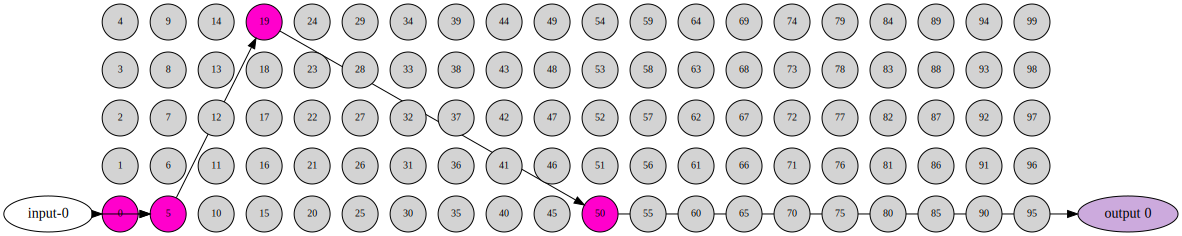

In [49]:
grid = plot_cartesian(individual)
SVG(grid.create(prog='neato', format='svg'))

MovieWriter imagemagick unavailable. Trying to use pillow instead.


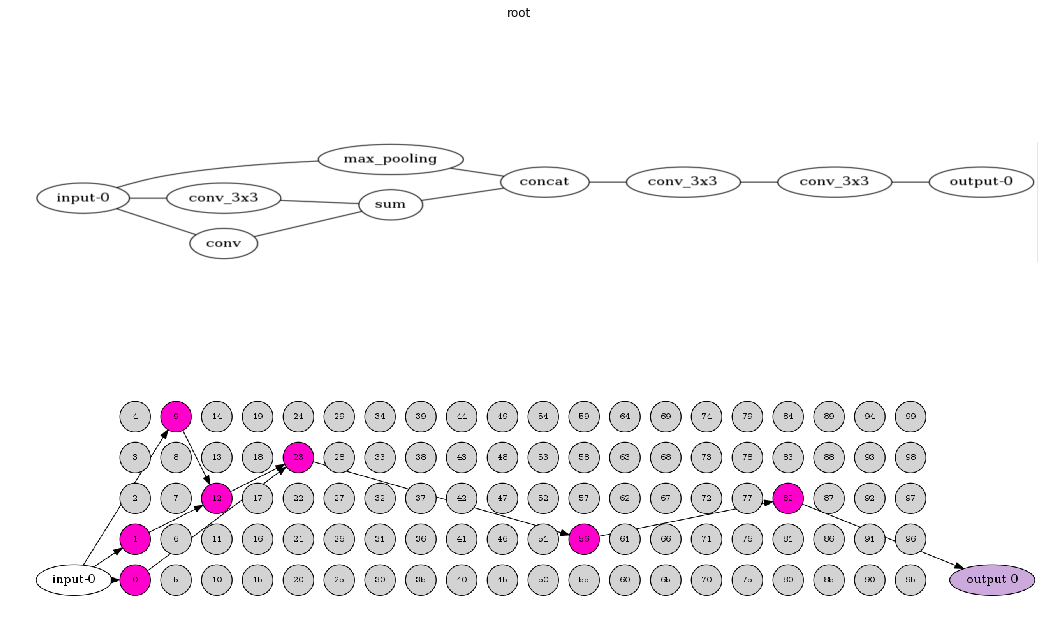

In [22]:
 class SubplotAnimation(animation.TimedAnimation):
    def __init__(self):
        graph = plot_graph(individual, rankdir='LR')
        grid = plot_cartesian(individual)
        graph.set('dpi', 300)
        grid.set('dpi', 300)
        
        self.mut_cnt = 0
        fig = plt.figure(figsize=(18,10))
        plt.subplot(2,1,1)
        self.title = plt.suptitle("root")
        plt.axis('off')
        img_graph = graph.create(prog='dot', format='png')
        self.im_graph = plt.imshow(Image.open(io.BytesIO(img_graph)), animated=True, aspect='equal', interpolation='bilinear')

        plt.subplot(2,1,2)
        plt.axis('off')
        img_grid = grid.create(prog='neato', format='png')
        self.im_grid = plt.imshow(Image.open(io.BytesIO(img_grid)), animated=True)        
        animation.TimedAnimation.__init__(self, fig, interval=2000, blit=True)
    
    def new_frame_seq(self):
        return range(10)

    def _draw_frame(self, framedata):
        self.mut_cnt += 1
        individual.mutate()
        graph = plot_graph(individual, rankdir='LR')
        grid = plot_cartesian(individual)
        img_graph = graph.create(prog='dot', format='png')
        img_grid = grid.create(prog='neato', format='png')
        self.title.text = "mutation %d" % self.mut_cnt
        self.im_graph.set_data(Image.open(io.BytesIO(img_graph)))
        self.im_grid.set_data(Image.open(io.BytesIO(img_grid)))
        self._drawn_artists = [self.im_graph, self.im_grid, self.title]
        

# anim = animation.FuncAnimation(fig, updatefig, init_func=init_func, frames=20, interval=1500, blit=False)
# write = animation.FFMpegWriter(fps=0.5, bitrate=1000, extra_args=['-vcodec', 'libx264'])
# anim.save('anim.mp4', writer=write, dpi=150)
anim = SubplotAnimation()
anim.save('anim.gif', dpi=300, writer='imagemagick')
# plt.close()